In [1]:
import os
import pandas as pd
from policies.mappo import MAPPO
from environment.optimization_environment import OptimizationEnv
from environment.utils import parse_config
from datetime import datetime
import numpy as np
import seaborn as sns

c:\Users\eikpon1\envs\RLEnv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [2]:
import os
import pandas as pd
from policies.mappo import MAPPO
from environment.optimization_environment import OptimizationEnv
from environment.utils import parse_config
from datetime import datetime
import numpy as np
import seaborn as sns

def initialize(config_path):
    env = OptimizationEnv(config_path)
    agent = MAPPO(config_path)
    return env, agent

def print_items(**kwargs):
    for key, value in kwargs.items():
        print(key, value)
        
def get_action(observation_info, agent, env):
    observation, observation_std = observation_info
    actions = np.zeros((env.n_agents, env.n_dim))
    for dim in range(env.n_dim):
        observation[dim] = observation[dim].astype(np.float32)
        observation_std[dim] = observation_std[dim].astype(np.float32)
        action = agent.select_action(observation[dim], observation_std[dim])
        actions[:, dim] = action
    return actions


def save_episode(env, df, episode, step, observation, state, action, reward, file_path='data/'):
    actual_state = env._get_actual_state()
    for agent in range(env.n_agents):
        df.loc[agent + step * env.n_agents] = {
            'step': step,
            'agent': agent,
            'scaled_dim1': state[agent][0],
            'scaled_dim2': state[agent][1],
            'scaled_value': state[agent][2],
            'real_dim1': actual_state[agent][0],
            'real_dim2': actual_state[agent][1],
            'real_value': actual_state[agent][2],
            'action': action[agent],
            'reward': reward[agent],
            'obs_1_value': observation[0][agent][0],
            #'obs_2_prev_diff_dim_1': observation[0][agent][1],
            'obs_3_prev_diff_value': observation[0][agent][1],
            'obs_4_pbest_diff_dim_1': observation[0][agent][2],
            'obs_5_pbest_diff_value': observation[0][agent][3],
            'obs_6_neigb_best_diff_dim_1': observation[0][agent][4],
            'obs_7_neigb_best_diff_value': observation[0][agent][5],
            'obs_8_random_neigh_diff_dim_1': observation[0][agent][6],
            'obs_9_random_neigh_diff_value': observation[0][agent][7],
            #'obs_10_prev_diff_dim_2': observation[1][agent][1],
            'obs_11_pbset_diff_dim_2': observation[1][agent][2],
            'obs_12_neigb_best_diff_dim_2': observation[1][agent][4],
            'obs_13_random_neigh_diff_dim_2': observation[1][agent][6],
        }
    if step == env.ep_length - 1:
        # sort by step 
        df = df.sort_values(by=['agent', 'step'])
        df.to_csv('{}{}.csv'.format(file_path, episode), index=False)
        df = pd.DataFrame(columns=['step', 'agent', 'scaled_dim1', 'scaled_dim2', 'scaled_value',
                                    'real_dim1', 'real_dim2', 'real_value', 'action', 'reward', 'obs_1_value',
                                      'obs_3_prev_diff_value', 'obs_4_pbest_diff_dim_1',
                                        'obs_5_pbest_diff_value', 'obs_6_neigb_best_diff_dim_1', 'obs_7_neigb_best_diff_value',
                                          'obs_8_random_neigh_diff_dim_1', 'obs_9_random_neigh_diff_value',
                                           'obs_11_pbset_diff_dim_2', 'obs_12_neigb_best_diff_dim_2',
                                              'obs_13_random_neigh_diff_dim_2'])
    #print('episode: {}, step: {}, length: {}'.format(episode, step, len(df)))
    return df


def train_agent(env, agent, n_episodes=2000, update_timestep=25, decay_rate=0.01, log_interval=200, min_action_std=0.1,
                decay_interval=1000, save_interval=2000):
    df = pd.DataFrame(columns=['step', 'agent', 'scaled_dim1', 'scaled_dim2', 'scaled_value',
                                    'real_dim1', 'real_dim2', 'real_value', 'action', 'reward', 'obs_1_value',
                                      'obs_3_prev_diff_value', 'obs_4_pbest_diff_dim_1',
                                        'obs_5_pbest_diff_value', 'obs_6_neigb_best_diff_dim_1', 'obs_7_neigb_best_diff_value',
                                          'obs_8_random_neigh_diff_dim_1', 'obs_9_random_neigh_diff_value',
                                             'obs_11_pbset_diff_dim_2', 'obs_12_neigb_best_diff_dim_2',
                                              'obs_13_random_neigh_diff_dim_2'])
    average_returns = []
    training_run_title = f"{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
    save_path = f"training_runs/{training_run_title}/"
    os.mkdir(save_path)
    timesteps = 0

    for episode in range(n_episodes):
        observation_info = env.reset()
        episode_return = np.zeros(env.n_agents)
        for step in range(env.ep_length):
            actions = get_action(observation_info, agent, env)
            observation_info, reward, done, info = env.step(actions)
            # add reward to agent buffer
            for ag in range(env.n_agents):
                agent.buffer.rewards += [reward[ag]] * env.n_dim
                agent.buffer.is_terminals += [done[ag]] * env.n_dim
            
            episode_return += reward
            if episode % log_interval == 0:
                df = save_episode(env, df, episode, step, observation_info[0], env.prev_state, actions, reward, file_path=save_path)


            if step == env.ep_length - 1:
                average_returns.append(np.mean(episode_return))
                running_average_rewards = np.mean(average_returns)
                
            timesteps += 1
        if timesteps % update_timestep == 0:
            agent.update()
    
        if episode % log_interval == 0 and timesteps > 0:
            print_items(
                    episode = episode,
                    average_returns = average_returns[-1],
                    timesteps = timesteps,
                )
            env.render(file_path=f"{save_path}{episode}.gif", type="history")
            
        if timesteps % decay_interval == 0:
            agent.decay_action_std(decay_rate, min_action_std=min_action_std)
            
        if timesteps % save_interval == 0 and timesteps > 0:
            if average_returns[-1] > running_average_rewards:
                print(f"Average return: {average_returns[-1]}, running average: {running_average_rewards}")
                agent.save(save_path, episode=timesteps)

    return average_returns


# if __name__ == "__main__":
#     config_path = 'config/config.json'
#     env, agent = initialize(config_path)
#     average_returns = train_agent(env, agent)


In [140]:
config_path = 'config/config.json'
env, agent = initialize(config_path)
config = parse_config(config_path)


In [192]:
obs = env.reset()
actions = get_action(obs, agent, env)
# mutiply actions by random number between - and 1
actions = actions * np.random.uniform(-1, 1, size=actions.shape)

In [210]:
actions = get_action(obs, agent, env)
print(actions)
# mutiply actions by random number between - and 1
actions = actions * np.random.uniform(-1, 1, size=actions.shape)
print(actions)
obs, reward, agents_done, info = env.step(actions)
print(env._get_actual_state())

[[-0.07318509 -0.1257742 ]
 [-0.14335504 -0.14174674]
 [-0.25338867 -0.12702991]
 [ 0.03813417 -0.22476985]
 [-0.11251967 -0.24715301]
 [-0.14291814  0.00035638]
 [-0.13534755 -0.09518047]
 [-0.20150943 -0.18670422]
 [-0.2676478  -0.30476144]
 [-0.23186913 -0.00661748]]
[[-0.01480879  0.00551967]
 [-0.08709683 -0.09441887]
 [-0.16479776  0.06017059]
 [ 0.03200775 -0.09297548]
 [ 0.06966776  0.21424227]
 [-0.00130024  0.00028186]
 [-0.0595142   0.01716645]
 [-0.17656575 -0.07545894]
 [ 0.14529021  0.12938616]
 [ 0.10665183 -0.00289529]]
[[ 0.8616     -0.989      -1.76211814]
 [-0.6472     -0.7702     -0.99661428]
 [ 0.6704     -0.8018     -1.03729439]
 [ 0.4264     -0.0146      0.00687575]
 [ 0.1052      0.654      -0.51296969]
 [-0.3688      0.558      -0.43808839]
 [ 0.8358      1.         -1.71388966]
 [ 0.4946     -1.         -1.33633201]
 [-0.7094     -0.7066     -0.97746457]
 [-0.4282      0.226      -0.23600405]]


In [211]:
env.gbest_history

array([[ 0.41      , -0.32      , -0.14082947],
       [ 0.41      , -0.32      , -0.14082947],
       [-0.081     ,  0.2282    , -0.11970391],
       [-0.081     ,  0.2282    , -0.1195807 ],
       [-0.081     ,  0.2282    , -0.1195807 ],
       [-0.081     ,  0.2282    , -0.1195807 ],
       [-0.081     ,  0.2282    , -0.1195807 ],
       [-0.081     ,  0.2282    , -0.1195807 ],
       [-0.081     ,  0.2282    , -0.1195807 ],
       [-0.081     ,  0.2282    , -0.1195807 ],
       [ 0.4264    , -0.0146    ,  0.00686564],
       [ 0.4264    , -0.0146    ,  0.00687575],
       [ 0.4264    , -0.0146    ,  0.00687575],
       [ 0.4264    , -0.0146    ,  0.00687575],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.   

In [212]:
env.state[env.best_agent]

array([0.7132, 0.4927, 0.9195])

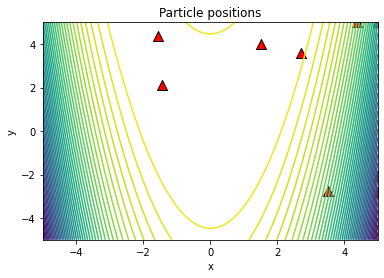

In [139]:
env.render(file_path='test.gif', type="state")

In [ ]:
# n_episodes = 2000
# n_steps = env.ep_length
# average_returns = []
# timesteps = 0
# update_timestep = 25
# decay_timestep = 100
# decay_rate = config['decay_rate']
# print('decay rate: {}'.format(decay_rate))

# average_returns = train_agent(env, agent, n_episodes=n_episodes, update_timestep=update_timestep, decay_rate=decay_rate, log_interval=200, min_action_std=0.1,
#                 decay_interval=decay_timestep, save_interval=2000)


## EVALUATE THE TRAINED MODEL

In [16]:
import matplotlib.pyplot as plt
model_path = "training_runs/2023-10-19_10-36-32/policy-16000.pth"
agent = MAPPO(config_path)
agent.load(model_path)
print(agent.policy.action_var)


Loaded policy from:  training_runs/2023-10-19_10-36-32/policy-16000.pth
tensor([0.0100], device='cuda:0')


In [10]:
def test(env, agent, n_steps):
    observation_info = env.reset()
    observation, observation_std = observation_info
    done = False
    best_agent_trajectory = np.zeros(shape=(env.ep_length, env.n_dim+1))
    for step in range(n_steps):
        actions = np.zeros((env.n_agents, env.n_dim))
        for dim in range(env.n_dim):
            # convert observation and std to float32
            observation[dim] = observation[dim].astype(np.float32)
            observation_std[dim] = observation_std[dim].astype(np.float32)
            action = agent.select_action(observation[dim], observation_std[dim])
            #print(agent.policy.action_var)
            actions[:, dim] = action
        # Go to the next state
        observation_info, reward, done, info = env.step(actions)
        best_agent_trajectory[step] = env._get_actual_state()[env.best_agent]
        observation, observation_std = observation_info
        # if done[0]:
        #     break
    return env, best_agent_trajectory

In [20]:
env, best_trajectory = test(env, agent, 25)
best_trajectory


array([[ 0.296     ,  0.082     , -0.49843919],
       [ 0.296     ,  0.082     , -0.49876995],
       [ 0.296     ,  0.082     , -0.49876995],
       [ 0.296     ,  0.082     , -0.49876995],
       [ 0.296     ,  0.082     , -0.49876995],
       [ 0.296     ,  0.082     , -0.49876995],
       [ 0.296     ,  0.082     , -0.49876995],
       [ 0.296     ,  0.082     , -0.49876995],
       [ 0.296     ,  0.082     , -0.49876995],
       [ 0.296     ,  0.082     , -0.49876995],
       [ 0.296     ,  0.082     , -0.49876995],
       [ 0.296     ,  0.082     , -0.49876995],
       [ 0.296     ,  0.082     , -0.49876995],
       [ 0.296     ,  0.082     , -0.49876995],
       [ 0.296     ,  0.082     , -0.49876995],
       [ 0.296     ,  0.082     , -0.49876995],
       [ 0.296     ,  0.082     , -0.49876995],
       [ 0.296     ,  0.082     , -0.49876995],
       [ 0.296     ,  0.082     , -0.49876995],
       [ 0.296     ,  0.082     , -0.49876995],
       [ 1.031     ,  1.048     , -0.021

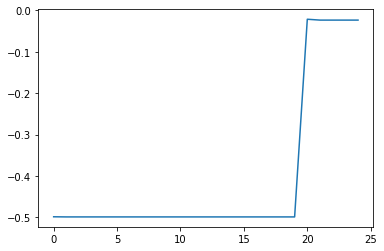

In [21]:
opt_vals = best_trajectory[:,-1]
plt.plot(opt_vals)

MovieWriter ffmpeg unavailable; using Pillow instead.


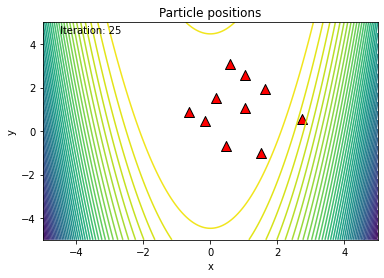

In [22]:
env.render(type="history", file_path="test.gif")

## EPISODE ANALYSIS

In [ ]:
df = pd.read_csv("training_runs/2023-10-14_22-22-16/1200.csv")

In [ ]:
import matplotlib.pyplot as plt
import re
# set dpi and plot style
plt.rcParams['figure.dpi'] = 300
plt.style.use('seaborn')



# Function to extract numerical values from the action strings
def extract_action_values(action_str):
    numbers = re.findall(r"-?\d+\.\d+", action_str)
    return [float(num) for num in numbers]

# Function to create trend plots for observations and actions
def plot_trends(agent_id, data, obs_string1='obs_2_prev_diff_dim_1', obs_string2='obs_10_prev_diff_dim_2'):
    agent_data = data[data['agent'] == agent_id]
    
    plt.figure(figsize=(12, 6))
    plt.plot(agent_data['step'], agent_data[f'{obs_string1}'], label=f'{obs_string1}', color='r', linestyle='-', marker='o')
    plt.plot(agent_data['step'], agent_data['action_dim1'], label='action_dim1', color='g', linestyle='--', marker='x')
    plt.plot(agent_data['step'], agent_data[f'{obs_string2}'], label=f'{obs_string2}', color='b', linestyle='-.', marker='s')
    plt.plot(agent_data['step'], agent_data['action_dim2'], label='action_dim2', color='m', linestyle=':', marker='d')
    plt.plot(agent_data['step'], agent_data['scaled_value'], label='scaled_value', color='c', linestyle='-', marker='*')
    
    plt.title(f'Trend Plot for Agent {agent_id}')
    plt.xlabel('Steps')
    plt.ylabel('Values')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to create path plots in scaled dimensions
def plot_paths(data, dimension):
    plt.figure(figsize=(12, 6))
    
    agents = data['agent'].unique()
    for agent in agents:
        agent_data = data[data['agent'] == agent]
        plt.plot(agent_data['step'], agent_data[f'scaled_{dimension}'], label=f'Agent {agent}', marker='o')
        
    plt.title(f'Agent Paths in Scaled {dimension.upper()}')
    plt.xlabel('Steps')
    plt.ylabel(f'Scaled {dimension.upper()}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to create value evolution plots
def plot_values(data):
    plt.figure(figsize=(12, 6))
    
    agents = data['agent'].unique()
    for agent in agents:
        agent_data = data[data['agent'] == agent]
        plt.plot(agent_data['step'], agent_data['scaled_value'], label=f'Agent {agent}', marker='o')
        
    plt.title('Agent Value Evolution')
    plt.xlabel('Steps')
    plt.ylabel('Scaled Value')
    plt.legend()
    plt.grid(True)
    plt.show()

def correlation_with_actions(data, dimension):
    # Calculating the correlation of all observations with actions in both dimensions
    correlation_with_actions = data.filter(regex='obs').apply(lambda x: x.corr(data[f'action_dim{dimension}']))
    
    # Combining the correlations for both dimensions into a DataFrame
    correlation_df = pd.DataFrame({
        'Observation': correlation_with_actions.index,
        f'Correlation_with_Action_Dim{dimension}': correlation_with_actions.values
    })
    
    # Displaying the correlations
    return correlation_df.sort_values(by=f'Correlation_with_Action_Dim{dimension}', ascending=False)

def plot_correlations(data, dimension):
    correlation_df = correlation_with_actions(data, dimension)
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_df, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, cbar_kws={'label': 'Correlation Coefficient'})
    plt.title(f'Correlation of Observations with Actions in Dimension {dimension}')
    plt.xlabel('Actions')
    plt.ylabel('Observations')
    plt.xticks(ticks=[0.5], labels=[f'Action_Dim{dimension}'])
    plt.yticks(rotation=0)
    plt.show()

# Main function to conduct the analysis
def analyze_agents(dataset_path, num_agents_to_plot=4):
    data = pd.read_csv(dataset_path)
    data[['action_dim1', 'action_dim2']] = pd.DataFrame(data['action'].apply(extract_action_values).tolist(), index=data.index)
    
    for agent in range(num_agents_to_plot):
        plot_trends(agent, data)
    
    plot_paths(data, 'dim1')
    plot_paths(data, 'dim2')
    plot_values(data)
    display_correlations(data)


# Function to calculate and display correlation coefficients
def display_correlations(data):
    dim1_columns = [col for col in data.columns if "obs" in col and "dim_1" in col]
    value_columns = [col for col in data.columns if "obs" in col and "value" in col]
    dim1_features = dim1_columns + value_columns + ['action_dim1']

    dim2_columns = [col for col in data.columns if "obs" in col and "dim_2" in col]
    dim2_features = dim2_columns + value_columns + ['action_dim2']
    
    correlation_dim1 = data[dim1_features].corr()['action_dim1']
    correlation_dim2 = data[dim2_features].corr()['action_dim2']
    
    print("Correlation Coefficients for Dimension 1:")
    print(correlation_dim1)
    print("\nCorrelation Coefficients for Dimension 2:")
    print(correlation_dim2)




In [ ]:
data.columns

In [ ]:
dataset_path = 'training_runs/2023-10-14_23-51-37/1200.csv'
data = pd.read_csv(dataset_path)
data[['action_dim1', 'action_dim2']] = pd.DataFrame(data['action'].apply(extract_action_values).tolist(), index=data.index)
obs1 = "obs_3_prev_diff_value"
obs2 = "obs_5_pbest_diff_value"
num_agents_to_plot = 4
for agent in range(num_agents_to_plot):
    plot_trends(agent, data, obs_string1=obs1, obs_string2=obs2)

In [ ]:
plot_paths(data, 'dim1')
plot_paths(data, 'dim2')
plot_values(data)

In [ ]:
display_correlations(data)